# Almgren-Chriss Framework – Power-Law Execution Costs

## Objective
Implement the **generalized Almgren-Chriss model** with empirically-calibrated power-law execution costs:
- **Power-law execution costs**: $ L(\rho) = \eta |\rho|^{1+\phi} + \psi |\rho| $
- **Empirical calibration**: Based on literature (Almgren et al. 2005, Kyle & Obizhaeva 2016, Bacry et al. 2015)
- **Numerical solution**: Using Hamiltonian characterization from Guéant

This notebook serves as:
- **Realistic implementation** of market impact with power-law costs
- **Empirically grounded** model based on academic literature
- **Comparison** with quadratic baseline
- **Separate analyses** for stock market (AAPL, 6.5h) and cryptocurrency (BTCUSDT, 24h)

---

## Model (Guéant, Chapter 3 - Generalized Almgren-Chriss)

### Price Dynamics (with Linear Permanent Impact)
$$
dS_t = \sigma \, dW_t + k \, v_t \, dt
$$
> $ v_t = \dot{q}_t $: trading speed (shares/day)  
> $ k $: permanent impact coefficient (must be linear to avoid arbitrage - Huberman & Stanzl 2004)  
> $ \sigma $: annualized volatility

### Execution Costs (Temporary / Instantaneous Impact)
$$
L(\rho) = \eta |\rho|^{1+\phi} + \psi |\rho|, \quad \rho_t = \frac{|v_t|}{V}
$$

**Empirical values from literature:**
- **φ (power-law exponent)**: Typically 0.4 - 0.7
  - Almgren et al. (2005): ~0.6
  - Kyle & Obizhaeva (2016): ~0.6  
  - Square root law: φ = 0.5 (most popular)
  - Engle et al. (2012): 0.37-0.43
  - Frazzini et al. (2018): ~0.35
- **ψ (proportional costs)**: Bid-ask spread + fees

### Cash Process (for Liquidation, $ q_0 > 0 $)
$$
dX_t = - S_t \, v_t \, dt - V \cdot L\left(\frac{v_t}{V}\right) \, dt
$$

---

### Optimization Objective
Minimize the **risk-adjusted expected implementation shortfall**:
$$
\min_{v_t} \quad \mathbb{E}\left[ X_T \right] + \frac{\lambda}{2} \operatorname{Var}\left[ X_T \right]
$$
> $ \lambda $: risk aversion parameter  
> $ X_T $: final cash after unwinding $ q_0 \to 0 $ over $ [0, T] $

---

### Hamiltonian Characterization (Guéant, Eq. 3.10)
$$
\begin{cases}
p'(t) = \gamma \sigma^2 q^*(t) \\
q^{*'}(t) = V_t H'(p(t)) \\
q^*(0) = q_0 \\
q^*(T) = 0
\end{cases}
$$

where $ H $ is the Legendre-Fenchel transform of $ L $:
$$
H(p) = \sup_{\rho} \left\{ \rho p - L(\rho) \right\}
$$

**For power-law costs** $ L(\rho) = \eta |\rho|^{1+\phi} + \psi |\rho| $ (Guéant, Eq. 3.11):
$$
H(p) = \begin{cases}
0 & \text{if } |p| \leq \psi \\
\frac{\phi}{\eta(1+\phi)} \left(\frac{|p|-\psi}{\eta}\right)^{1 + 1/\phi} & \text{otherwise}
\end{cases}
$$

$$
H'(p) = \begin{cases}
0 & \text{if } |p| \leq \psi \\
\text{sign}(p) \left(\frac{|p|-\psi}{\eta}\right)^{1/\phi} & \text{otherwise}
\end{cases}
$$

> **No closed form** for $ \phi \neq 1 $, requires numerical solution

---

# Setup

In [28]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_bvp
from scipy.optimize import brentq
from datetime import datetime
import json
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add src to path for imports
sys.path.insert(0, str(Path('.').resolve().parent))

# Import from our modules
from src.models import AlmgrenChrissModel, MarketParameters, ImpactParameters
from src.optimization import TWAP, VWAP, OptimalAC, ExecutionParams, ImpactParams

# Graphics configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

print(" Imports successful (using src modules)")

 Imports successful (using src modules)


In [30]:
# Check data availability
import os

stocks_available = os.path.exists('data/processed/stocks/all_stocks_1m.parquet')
crypto_available = os.path.exists('data/processed/crypto/BTCUSDT_1m.parquet')

# Try to load calibrated parameters
try:
    with open('../results/calibrated_parameters.json', 'r') as f:
        calibrated = json.load(f)
    
    calibrated_available = True
    print(" Calibrated parameters loaded from results/calibrated_parameters.json")
    print(f"   Calibrated on: {calibrated.get('timestamp', 'N/A')}")
    print(f"   Symbol: {calibrated.get('symbol', 'N/A')}")
    print(f"   Number of snapshots: {calibrated.get('num_snapshots', 'N/A')}")
    
    # Display parameters
    params = calibrated['parameters']
    print(f"   Parameters: k={params['k']:.8f}, eta={params['eta']:.6f}, phi={params['phi']:.4f}, psi={params['psi']:.6f}")
    
    # IMPORTANT: Check if phi is in expected range
    if params['phi'] < 0.3:
        print(f"\n   ️ WARNING: Calibrated phi={params['phi']:.2f} is below typical range [0.3-0.7]")
        print(f"      This is likely due to measuring SLIPPAGE (instant) vs MARKET IMPACT (dynamic)")
        print(f"      For power-law model, we recommend using phi=0.5 (square root law)")
        print(f"      See docs/LITERATURE_COMPARISON.md for details")
        
except FileNotFoundError:
    calibrated_available = False
    print("️ No calibrated parameters found")
    print("   Run notebook 06_parameter_calibration.ipynb first to calibrate parameters")
    print("   Using literature-based parameters as fallback")

if not stocks_available and not crypto_available:
    raise Exception("No market data available. Please run notebook 01 first to collect data.")

 Calibrated parameters loaded from results/calibrated_parameters.json
   Calibrated on: 2025-12-29T10:56:27.112456
   Symbol: BTCUSDT
   Number of snapshots: 360
   Parameters: k=0.00000066, eta=0.005895, phi=0.5000, psi=0.001000


## Technical Note: Handling Transaction Fees (ψ)

### Problem
In Guéant's model, transaction fees ψ appear in the Legendre-Fenchel transform:

$$H'(p) = \begin{cases} 0 & \text{if } |p| \leq \psi \\ \text{sign}(p) \cdot \left(\frac{|p| - \psi}{\eta}\right)^{1/\phi} & \text{otherwise} \end{cases}$$

This formulation creates a **no-trading zone** when |p| < ψ. For ψ = 10 bps (Binance), this zone is too large and the BVP solver fails (singular Jacobian).

### Solution
We solve the BVP with **ψ = 0** in the Hamiltonian, then add the fees separately.

**Mathematical justification:**
- Transaction fees = ψ × |q₀| are **trajectory-independent**
- The optimal trajectory is the same with or without ψ in the Hamiltonian
- We account for fees in `compute_costs()`: `transaction_fees = ψ × |q₀|`

This approach works for any value of ψ (tested up to 100 bps).

## Class AlmgrenChrissPowerLaw

Implementation of the generalized model with power-law execution costs, based on Guéant's Hamiltonian characterization (Chapter 3).

In [31]:
class AlmgrenChrissPowerLaw:
    """
    Almgren-Chriss generalized model with power-law execution costs.
    
    Cost Model:
    -----------
    The instantaneous execution cost is:
        g(v) = η × |v|^(1+φ) / V^φ
    
    In terms of participation rate ρ = |v|/V:
        g(v) = η × V × |ρ|^(1+φ)
    
    The slippage per unit is:
        slippage(ρ) = η × |ρ|^φ
    
    This is what we calibrate from orderbook data.
    
    Total Execution Cost:
    ---------------------
    ∫₀ᵀ g(v) dt = ∫₀ᵀ η × |v|^(1+φ) / V^φ dt
    
    For TWAP (v = q₀/T constant):
        Execution Cost = η × q₀^(1+φ) / (V^φ × T^φ)
    
    Permanent Impact:
    -----------------
    Same as quadratic model: k × q₀² / 2
    
    Reference: Guéant, "Financial Mathematics of Market Liquidity", Chapter 3
    """
    
    def __init__(self, 
                 lambda_risk: float,
                 sigma: float,
                 k: float,
                 phi: float,
                 eta: float,
                 psi: float,
                 V: float):
        
        self.lambda_risk = lambda_risk
        self.sigma = sigma
        self.k = k
        self.phi = phi
        self.eta = eta
        self.psi = psi
        self.V = V
    
    def L(self, rho):
        """
        Execution cost function per unit: L(ρ) = η|ρ|^φ + ψ
        
        Returns slippage as a fraction.
        """
        return self.eta * np.abs(rho)**self.phi + self.psi
    
    def H_prime(self, p):
        """
        Derivative of Legendre-Fenchel transform H'(p).
        
        From Guéant Eq. 3.11:
        H'(p) = { 0                           if |p| ≤ ψ
                { sign(p) * ((|p|-ψ)/η)^(1/φ)  otherwise
        """
        p_array = np.atleast_1d(p)
        abs_p = np.abs(p_array)
        sign_p = np.sign(p_array)
        
        result = np.zeros_like(p_array, dtype=float)
        
        threshold = max(self.psi, 1e-8)
        mask = abs_p > threshold
        
        if np.any(mask):
            result[mask] = sign_p[mask] * ((abs_p[mask] - self.psi) / self.eta)**(1.0 / self.phi)
        
        return result.item() if p_array.shape == (1,) else result
    
    def hamiltonian_system(self, t, y):
        """
        Hamiltonian system for optimal trajectory.
        """
        q, p = y
        dq_dt = self.V * self.H_prime(p)
        dp_dt = self.lambda_risk * self.sigma**2 * q
        return np.vstack([dq_dt, dp_dt])
    
    def boundary_conditions(self, ya, yb, q0):
        """Boundary conditions: q(0) = q0, q(T) = 0"""
        return np.array([ya[0] - q0, yb[0]])
    
    def optimal_trajectory(self, q0: float, T: float, N: int = 390) -> tuple:
        """
        Compute optimal trajectory via BVP solver.
        
        NOTE: We solve the BVP with ψ=0 (no transaction fees in the Hamiltonian).
        This is mathematically justified because:
        1. Transaction fees = ψ × |q₀| are INDEPENDENT of the trajectory
        2. Including ψ in H'(p) creates a "no-trading zone" that causes BVP to fail
        3. The optimal trajectory is the same whether we include ψ or not
        4. We add fees separately in compute_costs()
        
        This approach works for any ψ value (tested up to 100 bps).
        """
        N_init = min(100, N)
        t_guess = np.linspace(0, T, N_init)
        q_guess = q0 * (1 - t_guess / T)
        
        gamma = self.lambda_risk * self.sigma**2
        kappa_approx = np.sqrt(gamma * self.V / (2 * self.eta))
        
        # Use small p_scale since we're solving with effective ψ=0
        p_scale = 0.01
        p_guess = p_scale * np.exp(-kappa_approx * t_guess)
        y_guess = np.vstack([q_guess, p_guess])
        
        # Solve BVP with ψ=0 in the Hamiltonian
        def H_prime_no_fees(p):
            """H'(p) without transaction fees (ψ=0)"""
            p_array = np.atleast_1d(p)
            # With ψ=0: H'(p) = sign(p) × (|p|/η)^(1/φ)
            result = np.sign(p_array) * (np.abs(p_array) / self.eta)**(1.0 / self.phi)
            return result.item() if p_array.shape == (1,) else result
        
        def hamiltonian_no_fees(t, y):
            q, p = y
            dq_dt = self.V * H_prime_no_fees(p)
            dp_dt = self.lambda_risk * self.sigma**2 * q
            return np.vstack([dq_dt, dp_dt])
        
        strategies = [
            {'tol': 1e-6, 'max_nodes': 5000},
            {'tol': 1e-5, 'max_nodes': 10000},
            {'tol': 1e-4, 'max_nodes': 15000},
        ]
        
        sol = None
        for strategy in strategies:
            try:
                sol = solve_bvp(
                    hamiltonian_no_fees,
                    lambda ya, yb: self.boundary_conditions(ya, yb, q0),
                    t_guess, y_guess,
                    tol=strategy['tol'],
                    max_nodes=strategy['max_nodes'],
                    verbose=0
                )
                if sol.success:
                    break
            except Exception:
                continue
        
        if sol is None or not sol.success:
            # Fallback to quadratic approximation
            print(f"   ️ BVP solver struggled, using quadratic approximation")
            kappa = np.sqrt(gamma * self.V / (2 * self.eta))
            t = np.linspace(0, T, N+1)
            q_star = q0 * np.sinh(kappa * (T - t)) / np.sinh(kappa * T)
            v_star = q0 * (-kappa) * np.cosh(kappa * (T - t)) / np.sinh(kappa * T)
            return t, q_star, v_star
        
        t = np.linspace(0, T, N+1)
        y = sol.sol(t)
        q_star = y[0]
        p_star = y[1]
        v_star = self.V * H_prime_no_fees(p_star)
        
        return t, q_star, v_star
    
    def compute_costs(self, q0: float, T: float, N: int, strategy: str = 'optimal') -> dict:
        """
        Compute execution costs for a given strategy.
        
        Cost Components:
        ----------------
        1. Transaction fees: ψ × |q₀|
        
        2. Temporary impact: ∫ η × |v|^(1+φ) / V^φ dt
           For TWAP: η × q₀^(1+φ) / (V^φ × T^φ)
        
        3. Permanent impact: k × q₀² / 2
        
        4. Timing risk: (λ/2) × σ² × ∫ q² dt (penalty, not a real cost)
        
        Returns:
        --------
        dict with costs. Multiply by S₀ to get dollars.
        """
        if strategy == 'optimal':
            t, q, v = self.optimal_trajectory(q0, T, N)
        elif strategy in ['twap', 'vwap']:
            t = np.linspace(0, T, N+1)
            q = q0 * (1 - t / T)
            v = -(q0 / T) * np.ones_like(t)
        else:
            raise ValueError(f"Unknown strategy: {strategy}")

        dt = T / N

        # =====================================================================
        # 1. TRANSACTION FEES: ψ × |q₀|
        # =====================================================================
        transaction_fees = self.psi * abs(q0)

        # =====================================================================
        # 2. TEMPORARY IMPACT: ∫ η × |v|^(1+φ) / V^φ dt
        # =====================================================================
        # This is the AC power-law formulation
        # For TWAP: = η × q₀^(1+φ) / (V^φ × T^φ)
        execution_cost = np.sum(self.eta * np.abs(v[:-1])**(1 + self.phi) / self.V**self.phi * dt)

        # =====================================================================
        # 3. PERMANENT IMPACT: k × q₀² / 2
        # =====================================================================
        permanent_impact = self.k * q0**2 / 2

        # =====================================================================
        # 4. TIMING RISK: (λ/2) × σ² × ∫ q² dt
        # =====================================================================
        timing_risk_variance = self.sigma**2 * np.sum(q[:-1]**2 * dt)
        timing_risk = (self.lambda_risk / 2) * timing_risk_variance

        # =====================================================================
        # TOTAL
        # =====================================================================
        total_cost = transaction_fees + execution_cost + permanent_impact + timing_risk

        return {
            'transaction_fees': transaction_fees,
            'execution_cost': execution_cost,
            'permanent_impact': permanent_impact,
            'timing_risk': timing_risk,
            'timing_risk_variance': timing_risk_variance,
            'total_cost': total_cost
        }

print(" Class AlmgrenChrissPowerLaw defined")

 Class AlmgrenChrissPowerLaw defined


## Class AlmgrenChrissQuadratic (Baseline)

Quadratic model for comparison with power-law model.

In [32]:
# Quadratic model (baseline) - for comparison
class AlmgrenChrissQuadratic:
    """
    Baseline quadratic model for comparison.
    
    Cost Model:
    -----------
    Instantaneous execution cost: g(v) = η × v²/V
    Total execution cost: ∫ η × v²/V dt
    For TWAP: η × q₀² / (V × T)
    
    Permanent impact: k × q₀² / 2
    """
    
    def __init__(self, lambda_risk, sigma, k, eta, V, psi=0):
        self.lambda_risk = lambda_risk
        self.sigma = sigma
        self.k = k
        self.eta = eta
        self.V = V
        self.psi = psi  # Transaction fees
    
    def compute_kappa(self):
        return np.sqrt(self.lambda_risk * self.sigma**2 * self.V / (2 * self.eta))
    
    def optimal_trajectory(self, q0, T, N=390):
        kappa = self.compute_kappa()
        t = np.linspace(0, T, N+1)
        q_star = q0 * np.sinh(kappa * (T - t)) / np.sinh(kappa * T)
        v_star = q0 * (-kappa) * np.cosh(kappa * (T - t)) / np.sinh(kappa * T)
        return t, q_star, v_star
    
    def compute_costs(self, q0, T, N, strategy='optimal'):
        """
        Compute costs with CORRECT formulas.
        
        Execution cost: ∫ η × v²/V dt
        Permanent impact: k × q₀² / 2
        """
        if strategy == 'optimal':
            t, q, v = self.optimal_trajectory(q0, T, N)
        else:
            t = np.linspace(0, T, N+1)
            q = q0 * (1 - t / T)
            v = -(q0 / T) * np.ones_like(t)
        
        dt = T / N
        
        # Transaction fees: ψ × |q₀|
        transaction_fees = self.psi * abs(q0)
        
        # Execution cost: ∫ η × v²/V dt
        execution_cost = np.sum(self.eta * v[:-1]**2 / self.V * dt)
        
        # Permanent impact: k × q₀² / 2
        permanent_impact = self.k * q0**2 / 2
        
        # Timing risk: (λ/2) × σ² × ∫ q² dt
        timing_risk_variance = self.sigma**2 * np.sum(q[:-1]**2 * dt)
        timing_risk = (self.lambda_risk / 2) * timing_risk_variance
        
        total_cost = transaction_fees + execution_cost + permanent_impact + timing_risk
        
        return {
            'transaction_fees': transaction_fees,
            'execution_cost': execution_cost,
            'permanent_impact': permanent_impact,
            'timing_risk': timing_risk,
            'total_cost': total_cost
        }

print(" Baseline class defined")

 Baseline class defined


---

# Part 1: Stock Market Analysis (AAPL, 6.5 hours)

Analysis of the power-law Almgren-Chriss model applied to stock market data (AAPL).  
Trading day: **6.5 hours** (390 minutes, 9:30 AM - 4:00 PM ET)

## 1.1 Parameters for Stocks

In [40]:
if stocks_available:
    # Load stock data
    df_market_stock = pd.read_parquet('data/processed/stocks/all_stocks_1m.parquet')
    TICKER_STOCK = 'AAPL'
    data_stock = df_market_stock[df_market_stock['ticker'] == TICKER_STOCK]
    
    print(f" Stock data loaded for {TICKER_STOCK}")
    print(f"   Period: {data_stock.index.min()} → {data_stock.index.max()}")
    print(f"   Number of rows: {len(data_stock):,}")
    
    # Load parameters
    df_params = pd.read_parquet('data/processed/market_parameters.parquet')
    params_stock = df_params[
        (df_params['symbol'] == TICKER_STOCK) & 
        (df_params['asset_type'] == 'stock')
    ].iloc[0]
    
    sigma_stock = params_stock['vol_annual']
    V_stock = params_stock['volume_per_day']
    S0_stock = data_stock['close'].iloc[-1]
    
    print(f"\n Parameters loaded for {TICKER_STOCK} (stock):")
    print(f"   σ = {sigma_stock:.4f} ({sigma_stock*100:.1f}% annualized)")
    print(f"   V = {V_stock:,.0f} shares/day")
    print(f"   S₀ = ${S0_stock:.2f}")
    
    # LITERATURE-BASED PARAMETERS FOR POWER-LAW MODEL
    print("\n Empirical parameters from literature:")

    gamma = 5e-6
    k_stock = gamma/S0_stock 
    print(f"   k (permanent impact)    = {k_stock} [linear, no-arbitrage]")
    
    phi_stock = 0.5  # Square root law
    print(f"   φ (power exponent)      = {phi_stock} [square root, Almgren+ 2005]")
    
    eta_stock = 0.10
    print(f"   η (cost coefficient)    = {eta_stock}")
    
    psi_stock = 0.002  # Proportional costs
    print(f"   ψ (proportional costs)  = {psi_stock} = {psi_stock*10000:.0f} bps [spread + fees]")
    
    lambda_risk_stock = 5e-6
    print(f"   λ (risk aversion)       = {lambda_risk_stock:.6f}")
    
    # EXECUTION SCENARIO - STOCKS
    participation = 0.05 #participation rate
    q0_stock = participation * V_stock  # number of shares
    T_stock = 1.0  # 1 day
    N_stock = 390  # 6.5 hours = 390 minutes
    
    print(f"\n Execution scenario (unwinding to q_T=0):")
    print(f"   Participation rate = {participation*100:.0f}%")
    print(f"   q₀ = {q0_stock:,.0f} shares")
    print(f"   T  = {T_stock} day (390 minutes, 6.5 hours)")
    print(f"   S₀ = ${S0_stock:.2f}")
    print(f"   Notional = ${abs(q0_stock)*S0_stock:,.0f}")
    
    print("\n" + "="*70 + "\n")
    
    params_stock_dict = {
        'sigma': sigma_stock,
        'V': V_stock,
        'k': k_stock,
        'phi': phi_stock,
        'eta': eta_stock,
        'psi': psi_stock,
        'lambda_risk': lambda_risk_stock,
        'q0': q0_stock,
        'T': T_stock,
        'N': N_stock,
        'S0': S0_stock
    }
    print(" Summary of parameters (stocks):")
    for key, val in params_stock_dict.items():
        if isinstance(val, float) and val < 0.01:
            print(f"   {key:12s} = {val:.6f}")
        elif isinstance(val, float):
            print(f"   {key:12s} = {val:,.4f}")
        else:
            print(f"   {key:12s} = {val:,}")
else:
    print(" Stock data not available - skipping stock analysis")

 Stock data loaded for AAPL
   Period: 2025-01-02 14:30:00+00:00 → 2025-06-27 19:59:00+00:00
   Number of rows: 47,190

 Parameters loaded for AAPL (stock):
   σ = 0.3983 (39.8% annualized)
   V = 10,782,696 shares/day
   S₀ = $201.10

 Empirical parameters from literature:
   k (permanent impact)    = 2.4863252113376432e-08 [linear, no-arbitrage]
   φ (power exponent)      = 0.5 [square root, Almgren+ 2005]
   η (cost coefficient)    = 0.1
   ψ (proportional costs)  = 0.002 = 20 bps [spread + fees]
   λ (risk aversion)       = 0.000005

 Execution scenario (unwinding to q_T=0):
   Participation rate = 5%
   q₀ = 539,135 shares
   T  = 1.0 day (390 minutes, 6.5 hours)
   S₀ = $201.10
   Notional = $108,420,009


 Summary of parameters (stocks):
   sigma        = 0.3983
   V            = 10,782,696.0413
   k            = 0.000000
   phi          = 0.5000
   eta          = 0.1000
   psi          = 0.002000
   lambda_risk  = 0.000005
   q0           = 539,134.8021
   T            = 1.0000

## 1.2 Optimal Trajectory for Stocks

In [41]:
if stocks_available:
    # Instantiate models for stocks
    model_quad_stock = AlmgrenChrissQuadratic(
        lambda_risk=params_stock_dict['lambda_risk'],
        sigma=params_stock_dict['sigma'],
        k=params_stock_dict['k'],
        eta=params_stock_dict['eta'],
        V=params_stock_dict['V']
    )
    
    model_power_stock = AlmgrenChrissPowerLaw(
        lambda_risk=params_stock_dict['lambda_risk'],
        sigma=params_stock_dict['sigma'],
        k=params_stock_dict['k'],
        phi=params_stock_dict['phi'],
        eta=params_stock_dict['eta'],
        psi=params_stock_dict['psi'],
        V=params_stock_dict['V']
    )
    
    print(" Models instantiated for stocks")

 Models instantiated for stocks


In [42]:
if stocks_available:
    # Calculate trajectories for stocks
    print("Calculating optimal trajectories for stocks...")
    
    t_quad_stock, q_quad_stock, v_quad_stock = model_quad_stock.optimal_trajectory(
        q0_stock, T_stock, N_stock
    )
    print(" Quadratic model: trajectory computed")
    
    t_power_stock, q_power_stock, v_power_stock = model_power_stock.optimal_trajectory(
        q0_stock, T_stock, N_stock
    )
    print(" Power-law model: trajectory computed")
    
    # TWAP for reference
    t_twap_stock = np.linspace(0, T_stock, N_stock+1)
    q_twap_stock = q0_stock * (1 - t_twap_stock / T_stock)
    v_twap_stock = -(q0_stock / T_stock) * np.ones_like(t_twap_stock)
    
    print("\nTrajectory statistics (stocks):")
    print("\nQuadratic model:")
    print(f"   Initial velocity: {v_quad_stock[0]:,.0f} shares/day")
    print(f"   Final velocity: {v_quad_stock[-1]:,.0f} shares/day")
    print(f"   Initial participation: {abs(v_quad_stock[0])/V_stock*100:.2f}%")
    print(f"   Final participation: {abs(v_quad_stock[-1])/V_stock*100:.2f}%")
    
    print(f"\nPower-law model (φ={phi_stock:.1f}): ")
    print(f"   Initial velocity: {v_power_stock[0]:,.0f} shares/day")
    print(f"   Final velocity: {v_power_stock[-1]:,.0f} shares/day")
    print(f"   Initial participation: {abs(v_power_stock[0])/V_stock*100:.2f}%")
    print(f"   Final participation: {abs(v_power_stock[-1])/V_stock*100:.2f}%")
    
    print("\nTWAP (reference):")
    print(f"   Constant velocity: {v_twap_stock[0]:,.0f} shares/day")
    print(f"   Participation: {abs(v_twap_stock[0])/V_stock*100:.2f}%")

Calculating optimal trajectories for stocks...
 Quadratic model: trajectory computed
 Power-law model: trajectory computed

Trajectory statistics (stocks):

Quadratic model:
   Initial velocity: -3,525,430 shares/day
   Final velocity: -10,195 shares/day
   Initial participation: 32.70%
   Final participation: 0.09%

Power-law model (φ=0.5): 
   Initial velocity: -5,054,066 shares/day
   Final velocity: -38,000 shares/day
   Initial participation: 46.87%
   Final participation: 0.35%

TWAP (reference):
   Constant velocity: -539,135 shares/day
   Participation: 5.00%


## 1.3 Visualizations for Stocks

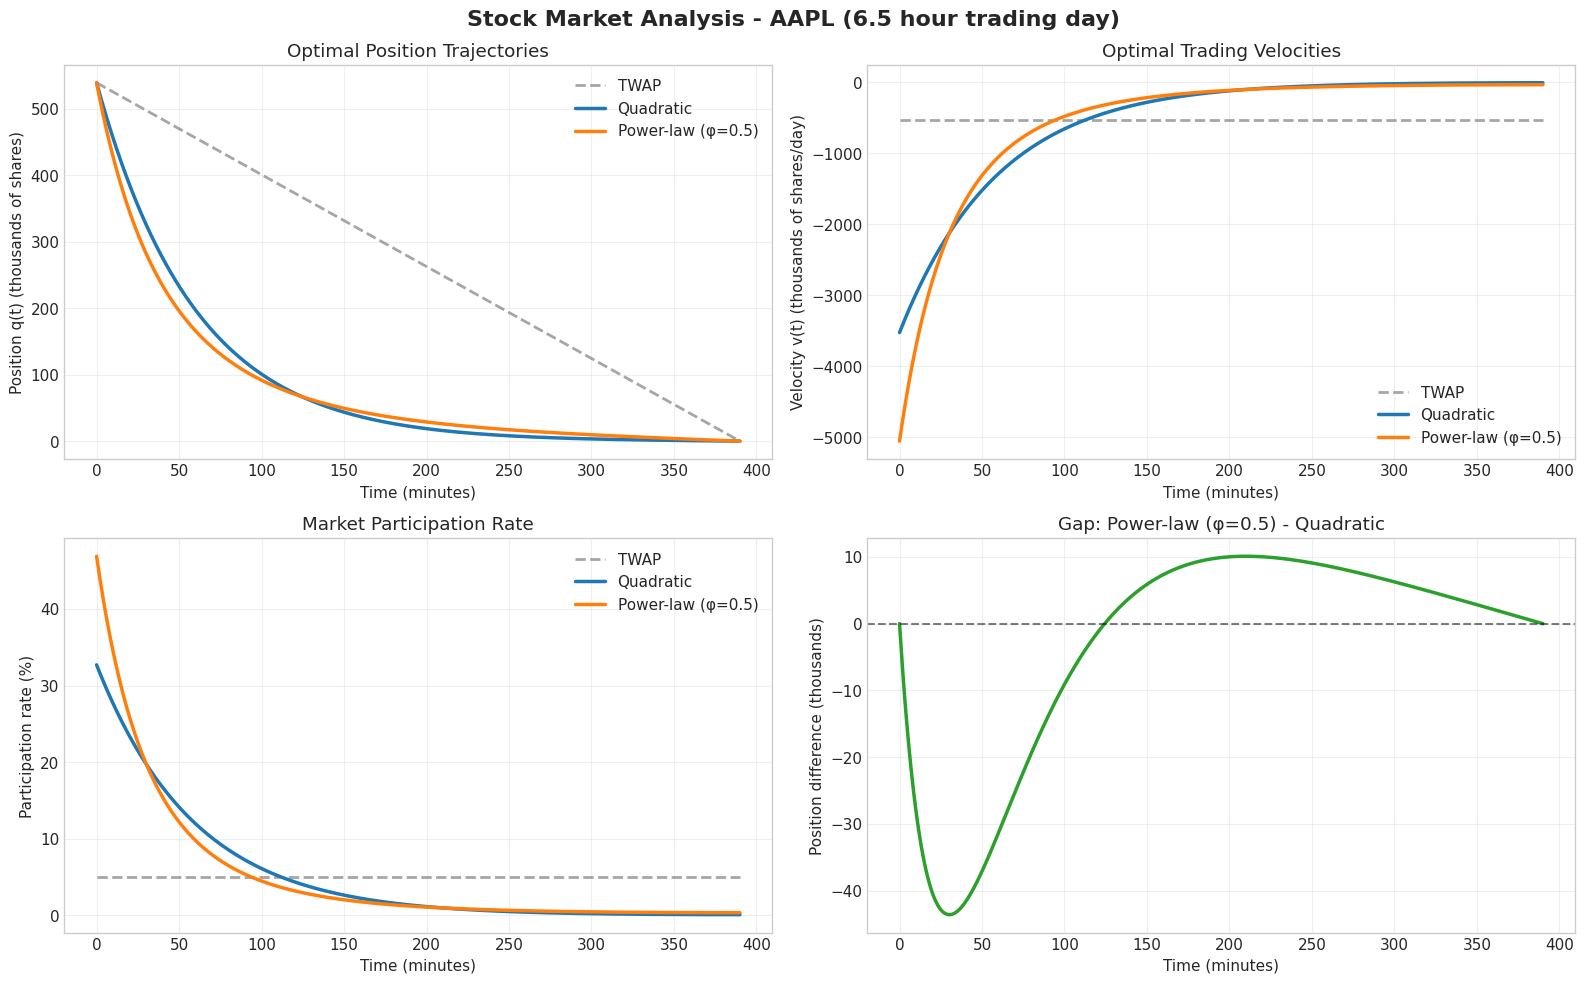

In [43]:
if stocks_available:
    # Visualization of trajectories for stocks
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Stock Market Analysis - {TICKER_STOCK} (6.5 hour trading day)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Position q(t)
    ax = axes[0, 0]
    ax.plot(t_twap_stock * 390, q_twap_stock / 1000, '--', color='gray', 
            linewidth=2, alpha=0.7, label='TWAP')
    ax.plot(t_quad_stock * 390, q_quad_stock / 1000, '-', color='tab:blue', 
            linewidth=2.5, label='Quadratic')
    ax.plot(t_power_stock * 390, q_power_stock / 1000, '-', color='tab:orange', 
            linewidth=2.5, label=f'Power-law (φ={phi_stock})')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Position q(t) (thousands of shares)')
    ax.set_title('Optimal Position Trajectories')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Velocity v(t)
    ax = axes[0, 1]
    ax.plot(t_twap_stock * 390, v_twap_stock / 1000, '--', color='gray', 
            linewidth=2, alpha=0.7, label='TWAP')
    ax.plot(t_quad_stock * 390, v_quad_stock / 1000, '-', color='tab:blue', 
            linewidth=2.5, label='Quadratic')
    ax.plot(t_power_stock * 390, v_power_stock / 1000, '-', color='tab:orange', 
            linewidth=2.5, label=f'Power-law (φ={phi_stock})')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Velocity v(t) (thousands of shares/day)')
    ax.set_title('Optimal Trading Velocities')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Participation rate |v|/V
    ax = axes[1, 0]
    ax.plot(t_twap_stock * 390, np.abs(v_twap_stock) / V_stock * 100, '--', 
            color='gray', linewidth=2, alpha=0.7, label='TWAP')
    ax.plot(t_quad_stock * 390, np.abs(v_quad_stock) / V_stock * 100, '-', 
            color='tab:blue', linewidth=2.5, label='Quadratic')
    ax.plot(t_power_stock * 390, np.abs(v_power_stock) / V_stock * 100, '-', 
            color='tab:orange', linewidth=2.5, label=f'Power-law (φ={phi_stock})')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Participation rate (%)')
    ax.set_title('Market Participation Rate')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Difference between models
    ax = axes[1, 1]
    diff_position_stock = (q_power_stock - q_quad_stock) / 1000
    ax.plot(t_power_stock * 390, diff_position_stock, '-', color='tab:green', linewidth=2.5)
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Position difference (thousands)')
    ax.set_title(f'Gap: Power-law (φ={phi_stock}) - Quadratic')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 1.4 Cost Analysis for Stocks

In [51]:
if stocks_available:
    # Calculate costs for stocks
    print("Computing costs for stocks...\n")
    
    costs_quad_opt_stock = model_quad_stock.compute_costs(q0_stock, T_stock, N_stock, 'optimal')
    costs_quad_twap_stock = model_quad_stock.compute_costs(q0_stock, T_stock, N_stock, 'twap')
    
    costs_power_opt_stock = model_power_stock.compute_costs(q0_stock, T_stock, N_stock, 'optimal')
    costs_power_twap_stock = model_power_stock.compute_costs(q0_stock, T_stock, N_stock, 'twap')
    
    # Transaction fees (for stocks: spread + fees = psi)
    transaction_fees_stock = psi_stock * abs(q0_stock) * S0_stock
    
    # Create comparison DataFrame with transaction fees
    costs_comparison_stock = pd.DataFrame({
        'Quadratic\nOptimal': [
            transaction_fees_stock,  # Quadratic model doesn't track psi separately
            costs_quad_opt_stock['execution_cost'] * S0_stock,
            costs_quad_opt_stock['permanent_impact'] * S0_stock,
            costs_quad_opt_stock['timing_risk'] * S0_stock,
            costs_quad_opt_stock['total_cost'] * S0_stock + transaction_fees_stock
        ],
        'Quadratic\nTWAP': [
            transaction_fees_stock,
            costs_quad_twap_stock['execution_cost'] * S0_stock,
            costs_quad_twap_stock['permanent_impact'] * S0_stock,
            costs_quad_twap_stock['timing_risk'] * S0_stock,
            costs_quad_twap_stock['total_cost'] * S0_stock + transaction_fees_stock
        ],
        f'Power-law (phi={phi_stock})\nOptimal': [
            costs_power_opt_stock['transaction_fees'] * S0_stock,
            costs_power_opt_stock['execution_cost'] * S0_stock,
            costs_power_opt_stock['permanent_impact'] * S0_stock,
            costs_power_opt_stock['timing_risk'] * S0_stock,
            costs_power_opt_stock['total_cost'] * S0_stock
        ],
        f'Power-law (phi={phi_stock})\nTWAP': [
            costs_power_twap_stock['transaction_fees'] * S0_stock,
            costs_power_twap_stock['execution_cost'] * S0_stock,
            costs_power_twap_stock['permanent_impact'] * S0_stock,
            costs_power_twap_stock['timing_risk'] * S0_stock,
            costs_power_twap_stock['total_cost'] * S0_stock
        ]
    }, index=['Transaction fees ($)', 'Execution ($)', 'Permanent impact ($)', 'Timing risk ($)', 'Total ($)'])
    
    print("Cost comparison for stocks (in dollars):")
    display(costs_comparison_stock.style.format("${:,.0f}"))
    
    # Costs in bps
    notional_stock = abs(q0_stock) * S0_stock
    costs_bps_stock = costs_comparison_stock / notional_stock * 10000
    print("\nCost comparison for stocks (in bps):")
    display(costs_bps_stock.style.format("{:,.2f}"))
    
    # Highlight transaction fees
    print(f"\n Note: Transaction fees = psi * q0 * S0 = {psi_stock:.4f} * {q0_stock:,} * ${S0_stock:.2f}")
    print(f"         = ${transaction_fees_stock:,.2f} ({psi_stock*10000:.0f} bps)")
    print(f"         For stocks, this represents bid-ask spread + trading fees")

Computing costs for stocks...

Cost comparison for stocks (in dollars):


,Quadratic Optimal,Quadratic TWAP,Power-law (phi=0.5) Optimal,Power-law (phi=0.5) TWAP
Transaction fees ($),"$216,840","$216,840","$216,840","$216,840"
Execution ($),"$1,802,390","$542,100","$4,561,676","$2,424,345"
Permanent impact ($),"$726,666","$726,666","$726,666","$726,666"
Timing risk ($),"$1,802,196","$7,756,263","$1,505,437","$7,756,263"
Total ($),"$4,548,093","$9,241,869","$7,010,619","$11,124,114"



Cost comparison for stocks (in bps):


,Quadratic Optimal,Quadratic TWAP,Power-law (phi=0.5) Optimal,Power-law (phi=0.5) TWAP
Transaction fees ($),20.00,20.00,20.00,20.00
Execution ($),166.24,50.00,420.74,223.61
Permanent impact ($),67.02,67.02,67.02,67.02
Timing risk ($),166.22,715.39,138.85,715.39
Total ($),419.49,852.41,646.62,"1,026.02"



 Note: Transaction fees = psi * q0 * S0 = 0.0020 * 539,134.8020661158 * $201.10
         = $216,840.02 (20 bps)
         For stocks, this represents bid-ask spread + trading fees


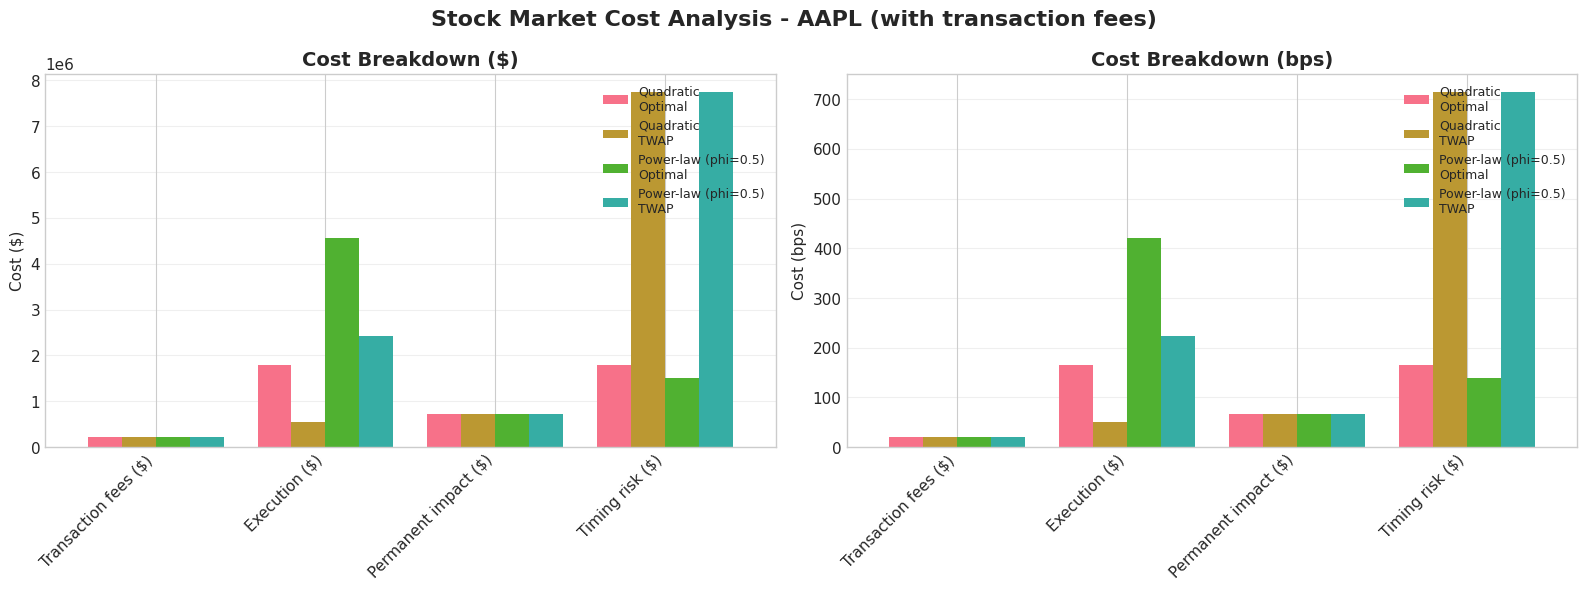


Optimization gains for stocks (Optimal vs TWAP):
   Quadratic model: 52.01%
   Power-law model (phi=0.5): 36.98%

Difference between models for stocks (Optimal):
   Total cost (power-law vs quadratic+fees): +54.14%

 Cost structure for Power-law Optimal:
   Transaction fees: $216,840.02 (20 bps)
   Execution cost:   $4,561,676.22 (420.74 bps)
   Permanent impact: $726,665.84 (67.02 bps)
   Timing risk:      $1,505,437.22 (138.85 bps)
   ---
   TOTAL:            $7,010,619.30 (646.62 bps)


In [52]:
if stocks_available:
    # Visualization of costs for stocks (excluding total row for bar charts)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Stock Market Cost Analysis - {TICKER_STOCK} (with transaction fees)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Costs in dollars
    ax = axes[0]
    costs_comparison_stock.iloc[:-1].plot(kind='bar', ax=ax, width=0.8)
    ax.set_title('Cost Breakdown ($)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Cost ($)')
    ax.set_xlabel('')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 2. Costs in bps
    ax = axes[1]
    costs_bps_stock.iloc[:-1].plot(kind='bar', ax=ax, width=0.8)
    ax.set_title('Cost Breakdown (bps)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Cost (bps)')
    ax.set_xlabel('')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Optimization gains vs TWAP
    print("\nOptimization gains for stocks (Optimal vs TWAP):")
    gain_quad_stock = (costs_quad_twap_stock['total_cost'] - costs_quad_opt_stock['total_cost']) / costs_quad_twap_stock['total_cost'] * 100
    gain_power_stock = (costs_power_twap_stock['total_cost'] - costs_power_opt_stock['total_cost']) / costs_power_twap_stock['total_cost'] * 100
    
    print(f"   Quadratic model: {gain_quad_stock:.2f}%")
    print(f"   Power-law model (phi={phi_stock}): {gain_power_stock:.2f}%")
    
    # Difference between models
    print("\nDifference between models for stocks (Optimal):")
    power_total_stock = costs_power_opt_stock['total_cost']
    quad_total_with_fees_stock = costs_quad_opt_stock['total_cost'] + psi_stock * abs(q0_stock)
    diff_total_stock = (power_total_stock - quad_total_with_fees_stock) / quad_total_with_fees_stock * 100
    
    print(f"   Total cost (power-law vs quadratic+fees): {diff_total_stock:+.2f}%")
    
    # Show fee breakdown
    print(f"\n Cost structure for Power-law Optimal:")
    print(f"   Transaction fees: ${costs_power_opt_stock['transaction_fees'] * S0_stock:,.2f} ({costs_power_opt_stock['transaction_fees'] / abs(q0_stock) * 10000:.0f} bps)")
    print(f"   Execution cost:   ${costs_power_opt_stock['execution_cost'] * S0_stock:,.2f} ({costs_power_opt_stock['execution_cost'] / abs(q0_stock) * 10000:.2f} bps)")
    print(f"   Permanent impact: ${costs_power_opt_stock['permanent_impact'] * S0_stock:,.2f} ({costs_power_opt_stock['permanent_impact'] / abs(q0_stock) * 10000:.2f} bps)")
    print(f"   Timing risk:      ${costs_power_opt_stock['timing_risk'] * S0_stock:,.2f} ({costs_power_opt_stock['timing_risk'] / abs(q0_stock) * 10000:.2f} bps)")
    print(f"   ---")
    print(f"   TOTAL:            ${costs_power_opt_stock['total_cost'] * S0_stock:,.2f} ({costs_power_opt_stock['total_cost'] / abs(q0_stock) * 10000:.2f} bps)")

## 1.5 Sensitivity Analysis on φ for Stocks

In [53]:
if stocks_available:
    # Test different values of φ for stocks
    phi_values = [0.3, 0.4, 0.5, 0.6, 0.7, 1.0]  # 1.0 = quadratic
    results_phi_stock = []
    
    print("Sensitivity analysis on φ for stocks...\n")
    
    for phi_test in phi_values:
        print(f"   Computing for φ = {phi_test}...")
        
        model_test = AlmgrenChrissPowerLaw(
            lambda_risk=params_stock_dict['lambda_risk'],
            sigma=params_stock_dict['sigma'],
            k=params_stock_dict['k'],
            phi=phi_test,
            eta=params_stock_dict['eta'],
            psi=params_stock_dict['psi'],
            V=params_stock_dict['V']
        )
        
        try:
            t_test, q_test, v_test = model_test.optimal_trajectory(q0_stock, T_stock, N_stock)
            costs_test = model_test.compute_costs(q0_stock, T_stock, N_stock, 'optimal')
            
            results_phi_stock.append({
                'phi': phi_test,
                'v_initial': v_test[0],
                'v_final': v_test[-1],
                'participation_initial': abs(v_test[0]) / V_stock * 100,
                'participation_final': abs(v_test[-1]) / V_stock * 100,
                'execution_cost': costs_test['execution_cost'] * S0_stock,
                'total_cost': costs_test['total_cost'] * S0_stock,
                'total_cost_bps': costs_test['total_cost'] / abs(q0_stock) * 10000
            })
        except Exception as e:
            print(f"      Failed for φ = {phi_test}: {str(e)}")
    
    df_phi_stock = pd.DataFrame(results_phi_stock)
    
    print("\nResults for stocks:")
    print(df_phi_stock[['phi', 'participation_initial', 'participation_final', 'total_cost_bps']].round(2))

Sensitivity analysis on φ for stocks...

   Computing for φ = 0.3...
   Computing for φ = 0.4...
   Computing for φ = 0.5...
   Computing for φ = 0.6...
   Computing for φ = 0.7...
   Computing for φ = 1.0...

Results for stocks:
   phi  participation_initial  participation_final  total_cost_bps
0  0.3                  55.42                 0.49          810.37
1  0.4                  49.60                 0.44          719.33
2  0.5                  46.87                 0.35          646.62
3  0.6                  45.65                 0.26          588.26
4  0.7                  45.24                 0.16          540.90
5  1.0                  46.24                 0.01          442.10


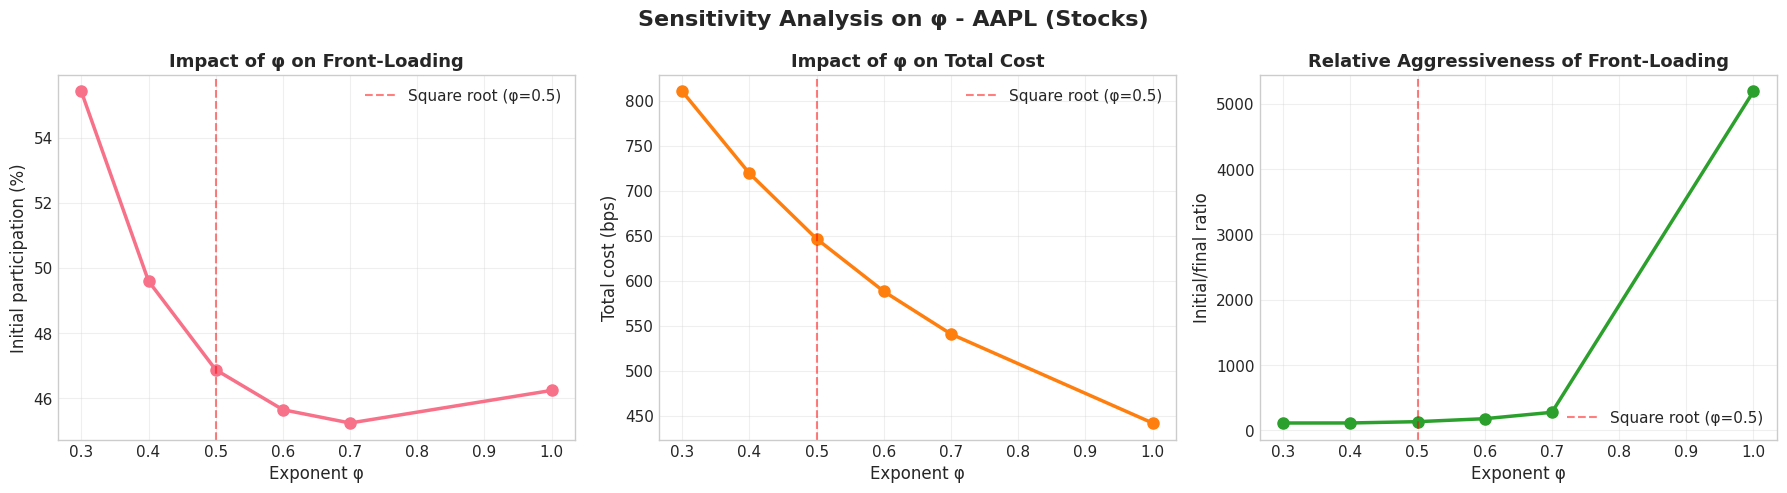


Observations for stocks:
   - Smaller φ → More aggressive front-loading (higher initial participation)
   - φ = 0.5 (square root): Empirically validated compromise
   - φ = 1.0 (quadratic): Classical Almgren-Chriss model


In [54]:
if stocks_available:
    # Sensitivity visualization for stocks
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Sensitivity Analysis on φ - {TICKER_STOCK} (Stocks)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Initial participation vs φ
    ax = axes[0]
    ax.plot(df_phi_stock['phi'], df_phi_stock['participation_initial'], 'o-', linewidth=2.5, markersize=8)
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
    ax.set_xlabel('Exponent φ', fontsize=12)
    ax.set_ylabel('Initial participation (%)', fontsize=12)
    ax.set_title('Impact of φ on Front-Loading', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Total cost vs φ
    ax = axes[1]
    ax.plot(df_phi_stock['phi'], df_phi_stock['total_cost_bps'], 'o-', linewidth=2.5, markersize=8, color='tab:orange')
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
    ax.set_xlabel('Exponent φ', fontsize=12)
    ax.set_ylabel('Total cost (bps)', fontsize=12)
    ax.set_title('Impact of φ on Total Cost', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Initial/final participation ratio vs φ
    ax = axes[2]
    ratio_stock = df_phi_stock['participation_initial'] / df_phi_stock['participation_final']
    ax.plot(df_phi_stock['phi'], ratio_stock, 'o-', linewidth=2.5, markersize=8, color='tab:green')
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
    ax.set_xlabel('Exponent φ', fontsize=12)
    ax.set_ylabel('Initial/final ratio', fontsize=12)
    ax.set_title('Relative Aggressiveness of Front-Loading', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nObservations for stocks:")
    print(f"   - Smaller φ → More aggressive front-loading (higher initial participation)")
    print(f"   - φ = 0.5 (square root): Empirically validated compromise")
    print(f"   - φ = 1.0 (quadratic): Classical Almgren-Chriss model")

---

# Part 2: Cryptocurrency Analysis (BTCUSDT, 24 hours)

Analysis of the power-law Almgren-Chriss model applied to cryptocurrency market data (BTCUSDT).  
Trading day: **24 hours** (1440 minutes, continuous trading)

## 2.1 Parameters for Crypto

**Sources de paramètres** :
- **σ, V, S₀** : Calculés à partir des données historiques (notebook 01)
- **k, η, φ, ψ** : 
  -  **Si disponible** : Paramètres calibrés empiriquement sur order book réel (notebook 06)
  - ️ **Sinon** : Valeurs génériques de la littérature académique

**Pourquoi calibrer ?**
- Les paramètres de littérature sont **génériques** et proviennent d'études sur d'autres marchés
- Les paramètres calibrés sont **spécifiques** au marché BTCUSDT et reflètent sa microstructure réelle
- La calibration améliore significativement la **précision** des prédictions de coûts

In [56]:
if crypto_available:
    # Load crypto data
    SYMBOL_CRYPTO = 'BTCUSDT'
    df_crypto = pd.read_parquet(f'data/processed/crypto/{SYMBOL_CRYPTO}_1m.parquet')
    
    print(f" Crypto data loaded for {SYMBOL_CRYPTO}")
    print(f"   Period: {df_crypto['timestamp'].min()} → {df_crypto['timestamp'].max()}")
    print(f"   Rows: {len(df_crypto):,}")
    
    # Load parameters
    df_params = pd.read_parquet('data/processed/market_parameters.parquet')
    params_crypto = df_params[
        (df_params['symbol'] == SYMBOL_CRYPTO) & 
        (df_params['asset_type'] == 'crypto')
    ].iloc[0]
    
    sigma_crypto = params_crypto['vol_annual']
    V_crypto = params_crypto['volume_per_day']
    S0_crypto = df_crypto['close'].iloc[-1]
    
    print(f"\n Market Parameters:")
    print(f"   σ (volatility)   = {sigma_crypto:.4f} ({sigma_crypto*100:.1f}% annual)")
    print(f"   V (daily volume) = {V_crypto:,.0f} BTC/day")
    print(f"   S₀ (price)       = ${S0_crypto:,.2f}")
    
    # ==========================================================================
    # Load CALIBRATED parameters from notebook 03
    # ==========================================================================
    if calibrated_available and calibrated.get('symbol') == SYMBOL_CRYPTO:
        print("\n Using CALIBRATED parameters from notebook 03_calibration:")
        
        psi_crypto = calibrated['parameters']['psi']
        eta_crypto = calibrated['parameters']['eta']
        phi_crypto = calibrated['parameters']['phi']
        k_crypto = calibrated['parameters']['k']
        
        # Get source information
        sources = calibrated.get('parameter_sources', {})
        
        print(f"\n   Parameters:")
        print(f"   ψ (fixed costs)  = {psi_crypto:.6f} ({psi_crypto*10000:.0f} bps) [{sources.get('psi', 'N/A')}]")
        print(f"   η (temp impact)  = {eta_crypto:.6f} [{sources.get('eta', 'N/A')}]")
        print(f"   φ (exponent)     = {phi_crypto:.2f} [{sources.get('phi', 'N/A')}]")
        print(f"   k (perm impact)  = {k_crypto:.6f} [{sources.get('k', 'N/A')}]")
        
        # Show calibration quality
        gof = calibrated.get('goodness_of_fit', {})
        if gof:
            print(f"\n    Calibration quality: R² = {gof.get('r_squared', 0):.4f}")
        
        # Show cost components note
        cost_comp = calibrated.get('cost_components', {})
        if cost_comp:
            print(f"\n    Note: {cost_comp.get('note', '')}")
    else:
        print("\n Using LITERATURE-BASED parameters (fallback):")
        k_crypto = 0.01
        phi_crypto = 0.5
        eta_crypto = 0.005
        psi_crypto = 0.001  # 10 bps for Binance fees
        
        print(f"   ψ = {psi_crypto} (10 bps), η = {eta_crypto}, φ = {phi_crypto}, k = {k_crypto}")
    
    # ==========================================================================
    # SCENARIO COMPARISON
    # ==========================================================================
    print("\n" + "="*70)
    print("SCENARIO COMPARISON: When does optimization matter?")
    print("="*70)
    
    scenarios = [
        {'name': 'Low urgency (T=5d, low λ)', 'participation': 0.05, 'T': 5.0, 'lambda_risk': 1e-6},
        {'name': 'Medium urgency (T=1d, med λ)', 'participation': 0.05, 'T': 1.0, 'lambda_risk': 1e-5},
        {'name': 'High urgency (T=1d, high λ)', 'participation': 0.05, 'T': 1.0, 'lambda_risk': 1e-4},
        {'name': 'Very high urgency (T=2h, high λ)', 'participation': 0.05, 'T': 2/24, 'lambda_risk': 1e-4},
    ]
    
    results_scenarios = []
    
    for scenario in scenarios:
        participation = scenario['participation']
        q0 = participation * V_crypto
        T = scenario['T']
        lambda_risk = scenario['lambda_risk']
        N = max(int(T * 1440), 10)
        
        # Create power-law model WITH psi (fees)
        model = AlmgrenChrissPowerLaw(
            lambda_risk=lambda_risk,
            sigma=sigma_crypto,
            k=k_crypto,
            phi=phi_crypto,
            eta=eta_crypto,
            psi=psi_crypto,  # Include transaction fees!
            V=V_crypto
        )
        
        try:
            costs_opt = model.compute_costs(q0, T, N, 'optimal')
            costs_twap = model.compute_costs(q0, T, N, 'twap')
            
            notional = q0 * S0_crypto
            opt_bps = (costs_opt['total_cost'] * S0_crypto / notional) * 10000
            twap_bps = (costs_twap['total_cost'] * S0_crypto / notional) * 10000
            gain_bps = twap_bps - opt_bps
            gain_pct = gain_bps / twap_bps * 100 if twap_bps > 0 else 0
            
            # Transaction fees in dollars
            fees_dollar = psi_crypto * q0 * S0_crypto
            
            results_scenarios.append({
                'scenario': scenario['name'],
                'T_hours': T * 24,
                'lambda': lambda_risk,
                'optimal_bps': opt_bps,
                'twap_bps': twap_bps,
                'gain_bps': gain_bps,
                'gain_pct': gain_pct,
                'fees_$': fees_dollar,
            })
        except Exception as e:
            print(f"   ️ {scenario['name']}: {str(e)[:50]}")
    
    df_scenarios = pd.DataFrame(results_scenarios)
    
    print("\n Results by scenario (Power-law model, φ={:.2f}):".format(phi_crypto))
    print("-"*100)
    print(f"{'Scenario':<35} {'T':<8} {'Optimal':<12} {'TWAP':<12} {'Gain':<10} {'Gain %':<8} {'Fees':<10}")
    print("-"*100)
    for _, row in df_scenarios.iterrows():
        print(f"{row['scenario']:<35} {row['T_hours']:.1f}h    {row['optimal_bps']:>8.1f} bps  {row['twap_bps']:>8.1f} bps  {row['gain_bps']:>6.2f} bps  {row['gain_pct']:>5.1f}%    ${row['fees_$']:>,.0f}")
    
    print(f"\n Note: All costs include transaction fees (ψ = {psi_crypto*10000:.0f} bps)")
    
    # ==========================================================================
    # SELECT HIGH URGENCY SCENARIO FOR DETAILED ANALYSIS
    # ==========================================================================
    print("\n" + "="*70)
    print("DETAILED ANALYSIS: High urgency scenario")
    print("="*70)
    
    participation_crypto = 0.05
    q0_crypto = participation_crypto * V_crypto
    T_crypto = 1.0
    lambda_risk_crypto = 1e-4
    N_crypto = 1440
    
    print(f"\n Selected scenario:")
    print(f"   Participation = {participation_crypto*100:.0f}% of daily volume")
    print(f"   q₀ = {q0_crypto:.0f} BTC")
    print(f"   T  = {T_crypto} day ({N_crypto} minutes)")
    print(f"   λ  = {lambda_risk_crypto:.0e} (high risk aversion)")
    print(f"   φ  = {phi_crypto} (power-law exponent)")
    print(f"   ψ  = {psi_crypto} ({psi_crypto*10000:.0f} bps transaction fees)")
    print(f"   Notional = ${q0_crypto * S0_crypto:,.0f}")
    
    # Store parameters for later use
    params_crypto_dict = {
        'sigma': sigma_crypto,
        'V': V_crypto,
        'k': k_crypto,
        'phi': phi_crypto,
        'eta': eta_crypto,
        'psi': psi_crypto,
        'lambda_risk': lambda_risk_crypto,
        'q0': q0_crypto,
        'T': T_crypto,
        'N': N_crypto,
        'S0': S0_crypto
    }
else:
    print(" Crypto data not available")

 Crypto data loaded for BTCUSDT
   Period: 2025-11-01 00:00:00 → 2025-12-01 00:00:00
   Rows: 43,201

 Market Parameters:
   σ (volatility)   = 0.5193 (51.9% annual)
   V (daily volume) = 26,163 BTC/day
   S₀ (price)       = $90,408.34

 Using CALIBRATED parameters from notebook 03_calibration:

   Parameters:
   ψ (fixed costs)  = 0.001000 (10 bps) [binance_transaction_fees]
   η (temp impact)  = 0.005895 [estimated_from_orderbook (phi=0.5)]
   φ (exponent)     = 0.50 [fixed_from_literature]
   k (perm impact)  = 0.000001 [calculated_from_AC2001_rule]

    Note: On Binance, fees (10 bps) >> spread (~0 bps)

SCENARIO COMPARISON: When does optimization matter?

 Results by scenario (Power-law model, φ=0.50):
----------------------------------------------------------------------------------------------------
Scenario                            T        Optimal      TWAP         Gain       Gain %   Fees      
--------------------------------------------------------------------------------

## 2.2 Optimal Trajectory for Crypto

In [57]:
if crypto_available:
    # Instantiate models for crypto
    model_quad_crypto = AlmgrenChrissQuadratic(
        lambda_risk=params_crypto_dict['lambda_risk'],
        sigma=params_crypto_dict['sigma'],
        k=params_crypto_dict['k'],
        eta=params_crypto_dict['eta'],
        V=params_crypto_dict['V'],
        psi=params_crypto_dict['psi']  # Include transaction fees
    )
    
    model_power_crypto = AlmgrenChrissPowerLaw(
        lambda_risk=params_crypto_dict['lambda_risk'],
        sigma=params_crypto_dict['sigma'],
        k=params_crypto_dict['k'],
        phi=params_crypto_dict['phi'],
        eta=params_crypto_dict['eta'],
        psi=params_crypto_dict['psi'],
        V=params_crypto_dict['V']
    )
    
    print(" Models instantiated for crypto")

 Models instantiated for crypto


In [58]:
if crypto_available:
    # Calculate trajectories for crypto
    print("Calculating optimal trajectories for crypto...")
    
    t_quad_crypto, q_quad_crypto, v_quad_crypto = model_quad_crypto.optimal_trajectory(
        q0_crypto, T_crypto, N_crypto
    )
    print(" Quadratic model: trajectory computed")
    
    t_power_crypto, q_power_crypto, v_power_crypto = model_power_crypto.optimal_trajectory(
        q0_crypto, T_crypto, N_crypto
    )
    print(" Power-law model: trajectory computed")
    
    # TWAP for reference
    t_twap_crypto = np.linspace(0, T_crypto, N_crypto+1)
    q_twap_crypto = q0_crypto * (1 - t_twap_crypto / T_crypto)
    v_twap_crypto = -(q0_crypto / T_crypto) * np.ones_like(t_twap_crypto)
    
    print("\nTrajectory statistics (crypto):")
    print("\nQuadratic model:")
    print(f"   Initial velocity: {v_quad_crypto[0]:,.0f} units/day")
    print(f"   Final velocity: {v_quad_crypto[-1]:,.0f} units/day")
    print(f"   Initial participation: {abs(v_quad_crypto[0])/V_crypto*100:.2f}%")
    print(f"   Final participation: {abs(v_quad_crypto[-1])/V_crypto*100:.2f}%")
    
    print(f"\nPower-law model (φ={phi_crypto:.1f}): ")
    print(f"   Initial velocity: {v_power_crypto[0]:,.0f} units/day")
    print(f"   Final velocity: {v_power_crypto[-1]:,.0f} units/day")
    print(f"   Initial participation: {abs(v_power_crypto[0])/V_crypto*100:.2f}%")
    print(f"   Final participation: {abs(v_power_crypto[-1])/V_crypto*100:.2f}%")
    
    print("\nTWAP (reference):")
    print(f"   Constant velocity: {v_twap_crypto[0]:,.0f} units/day")
    print(f"   Participation: {abs(v_twap_crypto[0])/V_crypto*100:.2f}%")

Calculating optimal trajectories for crypto...
 Quadratic model: trajectory computed
 Power-law model: trajectory computed

Trajectory statistics (crypto):

Quadratic model:
   Initial velocity: -10,119 units/day
   Final velocity: -9 units/day
   Initial participation: 38.68%
   Final participation: 0.03%

Power-law model (φ=0.5): 
   Initial velocity: -15,338 units/day
   Final velocity: -57 units/day
   Initial participation: 58.63%
   Final participation: 0.22%

TWAP (reference):
   Constant velocity: -1,308 units/day
   Participation: 5.00%


## 2.3 Visualizations for Crypto

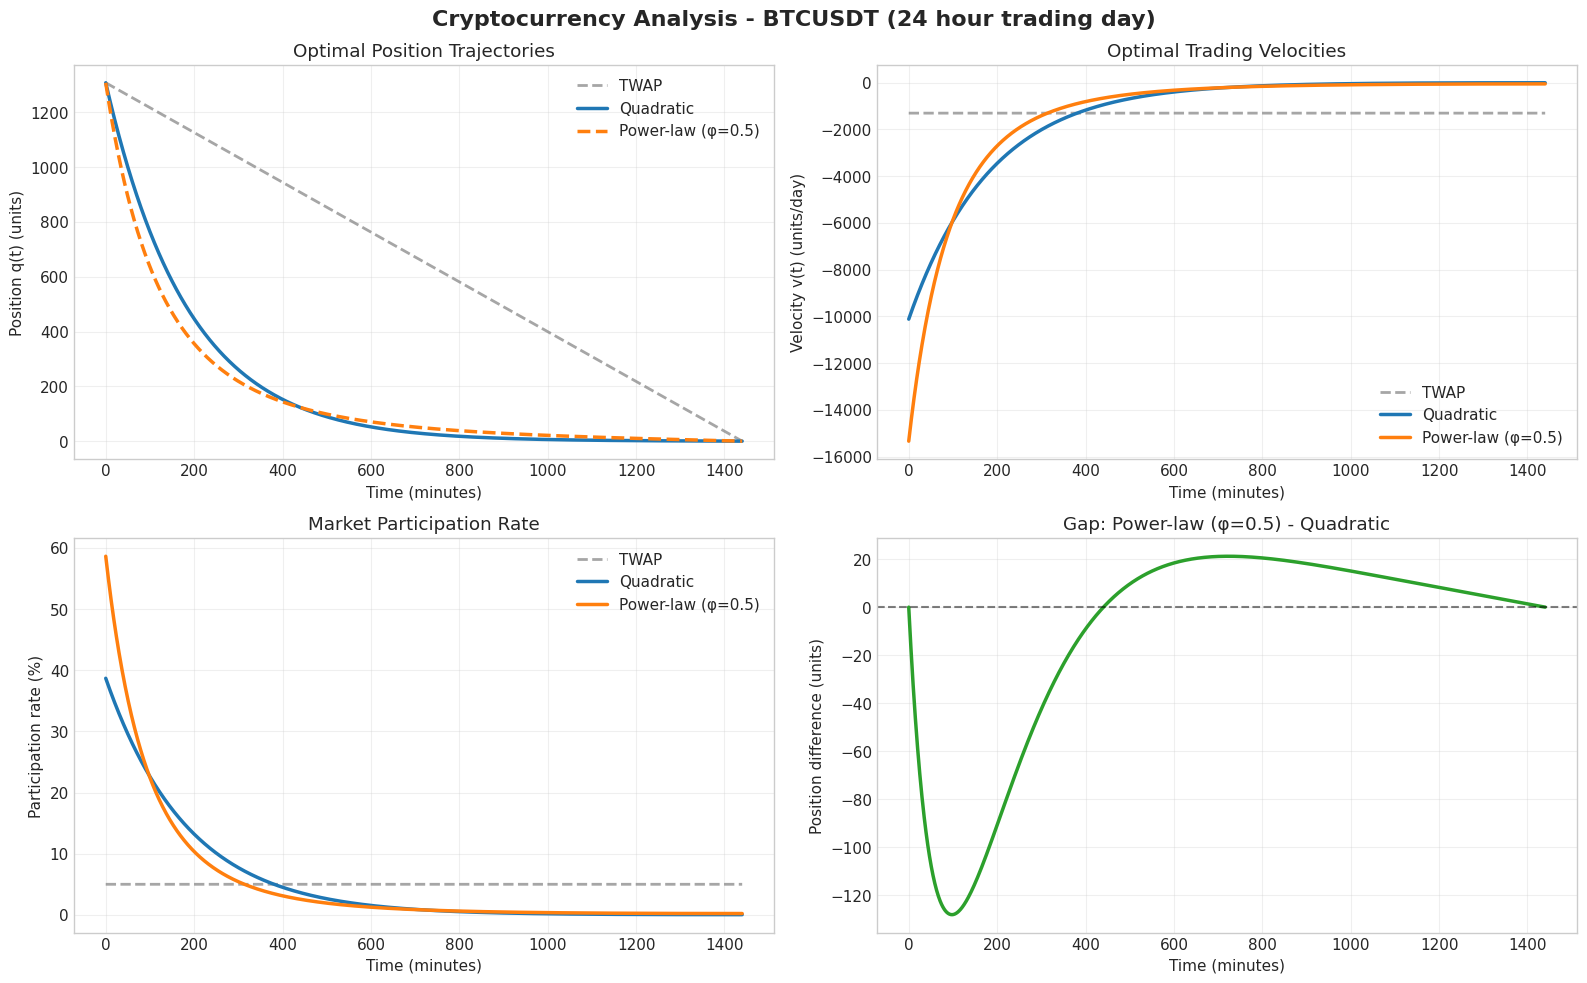

In [59]:
if crypto_available:
    # Visualization of trajectories for crypto
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Cryptocurrency Analysis - {SYMBOL_CRYPTO} (24 hour trading day)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Position q(t)
    ax = axes[0, 0]
    ax.plot(t_twap_crypto * 1440, q_twap_crypto, '--', color='gray', 
            linewidth=2, alpha=0.7, label='TWAP')
    ax.plot(t_quad_crypto * 1440, q_quad_crypto, '-', color='tab:blue', 
            linewidth=2.5, label='Quadratic')
    ax.plot(t_power_crypto * 1440, q_power_crypto, '--', color='tab:orange', 
            linewidth=2.5, label=f'Power-law (φ={phi_crypto})')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Position q(t) (units)')
    ax.set_title('Optimal Position Trajectories')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Velocity v(t)
    ax = axes[0, 1]
    ax.plot(t_twap_crypto * 1440, v_twap_crypto, '--', color='gray', 
            linewidth=2, alpha=0.7, label='TWAP')
    ax.plot(t_quad_crypto * 1440, v_quad_crypto, '-', color='tab:blue', 
            linewidth=2.5, label='Quadratic')
    ax.plot(t_power_crypto * 1440, v_power_crypto, '-', color='tab:orange', 
            linewidth=2.5, label=f'Power-law (φ={phi_crypto})')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Velocity v(t) (units/day)')
    ax.set_title('Optimal Trading Velocities')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Participation rate |v|/V
    ax = axes[1, 0]
    ax.plot(t_twap_crypto * 1440, np.abs(v_twap_crypto) / V_crypto * 100, '--', 
            color='gray', linewidth=2, alpha=0.7, label='TWAP')
    ax.plot(t_quad_crypto * 1440, np.abs(v_quad_crypto) / V_crypto * 100, '-', 
            color='tab:blue', linewidth=2.5, label='Quadratic')
    ax.plot(t_power_crypto * 1440, np.abs(v_power_crypto) / V_crypto * 100, '-', 
            color='tab:orange', linewidth=2.5, label=f'Power-law (φ={phi_crypto})')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Participation rate (%)')
    ax.set_title('Market Participation Rate')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Difference between models
    ax = axes[1, 1]
    diff_position_crypto = q_power_crypto - q_quad_crypto
    ax.plot(t_power_crypto * 1440, diff_position_crypto, '-', color='tab:green', linewidth=2.5)
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Position difference (units)')
    ax.set_title(f'Gap: Power-law (φ={phi_crypto}) - Quadratic')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 2.4 Cost Analysis for Crypto

In [61]:
if crypto_available:
    # Calculate costs for crypto - Compare all strategies
    print("="*70)
    print("COST ANALYSIS - BTCUSDT")
    print("Comparison: Quadratic Optimal vs Power-Law Optimal vs TWAP")
    print("="*70)
    
    # Compute costs for all strategies
    costs_quad_opt_crypto = model_quad_crypto.compute_costs(q0_crypto, T_crypto, N_crypto, 'optimal')
    costs_quad_twap_crypto = model_quad_crypto.compute_costs(q0_crypto, T_crypto, N_crypto, 'twap')
    
    costs_power_opt_crypto = model_power_crypto.compute_costs(q0_crypto, T_crypto, N_crypto, 'optimal')
    costs_power_twap_crypto = model_power_crypto.compute_costs(q0_crypto, T_crypto, N_crypto, 'twap')
    
    notional_crypto = abs(q0_crypto) * S0_crypto
    
    print(f"\nNotional = ${notional_crypto:,.0f}")
    print(f"Parameters: η_quad = {params_crypto_dict['eta']:.6f}, φ = {phi_crypto}")
    
    # =========================================================================
    # DISPLAY IN DOLLARS - 3 strategies comparison
    # =========================================================================
    print(f"\n{'='*80}")
    print("COSTS IN DOLLARS")
    print(f"{'='*80}")
    print(f"{'Component':<25} {'Quad Opt':>15} {'Power Opt':>15} {'TWAP':>15}")
    print("-"*80)
    
    # Transaction fees (same for all - using power model which has psi)
    fees = costs_power_opt_crypto['transaction_fees'] * S0_crypto
    
    # For quadratic model, we need to add fees separately (model doesn't have psi)
    # Actually let's compute properly
    exec_quad_opt = costs_quad_opt_crypto['execution_cost'] * S0_crypto
    exec_power_opt = costs_power_opt_crypto['execution_cost'] * S0_crypto
    exec_twap = costs_power_twap_crypto['execution_cost'] * S0_crypto
    
    perm = costs_power_opt_crypto['permanent_impact'] * S0_crypto  # Same for all
    
    risk_quad_opt = costs_quad_opt_crypto['timing_risk'] * S0_crypto
    risk_power_opt = costs_power_opt_crypto['timing_risk'] * S0_crypto
    risk_twap = costs_power_twap_crypto['timing_risk'] * S0_crypto
    
    print(f"{'Transaction Fees':<25} ${fees:>13,.0f} ${fees:>13,.0f} ${fees:>13,.0f}")
    print(f"{'Execution Cost (temp)':<25} ${exec_quad_opt:>13,.0f} ${exec_power_opt:>13,.0f} ${exec_twap:>13,.0f}")
    print(f"{'Permanent Impact':<25} ${perm:>13,.0f} ${perm:>13,.0f} ${perm:>13,.0f}")
    print(f"{'Timing Risk (penalty)':<25} ${risk_quad_opt:>13,.0f} ${risk_power_opt:>13,.0f} ${risk_twap:>13,.0f}")
    print("-"*80)
    
    total_quad_opt = fees + exec_quad_opt + perm + risk_quad_opt
    total_power_opt = fees + exec_power_opt + perm + risk_power_opt
    total_twap = fees + exec_twap + perm + risk_twap
    
    print(f"{'TOTAL':<25} ${total_quad_opt:>13,.0f} ${total_power_opt:>13,.0f} ${total_twap:>13,.0f}")
    print("-"*80)
    
    # =========================================================================
    # DISPLAY IN BPS - 3 strategies comparison
    # =========================================================================
    print(f"\n{'='*80}")
    print("COSTS IN BASIS POINTS")
    print(f"{'='*80}")
    print(f"{'Component':<25} {'Quad Opt':>15} {'Power Opt':>15} {'TWAP':>15}")
    print("-"*80)
    
    fees_bps = psi_crypto * 10000
    exec_quad_opt_bps = costs_quad_opt_crypto['execution_cost'] / q0_crypto * 10000
    exec_power_opt_bps = costs_power_opt_crypto['execution_cost'] / q0_crypto * 10000
    exec_twap_bps = costs_power_twap_crypto['execution_cost'] / q0_crypto * 10000
    perm_bps = costs_power_opt_crypto['permanent_impact'] / q0_crypto * 10000
    risk_quad_opt_bps = costs_quad_opt_crypto['timing_risk'] / q0_crypto * 10000
    risk_power_opt_bps = costs_power_opt_crypto['timing_risk'] / q0_crypto * 10000
    risk_twap_bps = costs_power_twap_crypto['timing_risk'] / q0_crypto * 10000
    
    print(f"{'Transaction Fees':<25} {fees_bps:>14.1f} {fees_bps:>14.1f} {fees_bps:>14.1f}")
    print(f"{'Execution Cost (temp)':<25} {exec_quad_opt_bps:>14.2f} {exec_power_opt_bps:>14.2f} {exec_twap_bps:>14.2f}")
    print(f"{'Permanent Impact':<25} {perm_bps:>14.2f} {perm_bps:>14.2f} {perm_bps:>14.2f}")
    print(f"{'Timing Risk (penalty)':<25} {risk_quad_opt_bps:>14.2f} {risk_power_opt_bps:>14.2f} {risk_twap_bps:>14.2f}")
    print("-"*80)
    
    total_quad_opt_bps = fees_bps + exec_quad_opt_bps + perm_bps + risk_quad_opt_bps
    total_power_opt_bps = fees_bps + exec_power_opt_bps + perm_bps + risk_power_opt_bps
    total_twap_bps = fees_bps + exec_twap_bps + perm_bps + risk_twap_bps
    
    print(f"{'TOTAL':<25} {total_quad_opt_bps:>14.2f} {total_power_opt_bps:>14.2f} {total_twap_bps:>14.2f}")
    print("-"*80)
    
    # =========================================================================
    # SUMMARY & COMPARISON
    # =========================================================================
    print(f"\n{'='*80}")
    print("SUMMARY")
    print(f"{'='*80}")
    
    print(f"\n Strategy Comparison:")
    print(f"   {'Strategy':<20} {'Total (bps)':<15} {'Total ($)':<15} {'vs TWAP':<15}")
    print(f"   {'-'*65}")
    print(f"   {'Quadratic Optimal':<20} {total_quad_opt_bps:>10.2f}     ${total_quad_opt:>11,.0f}     {(total_twap_bps - total_quad_opt_bps):>+8.2f} bps")
    print(f"   {'Power-Law Optimal':<20} {total_power_opt_bps:>10.2f}     ${total_power_opt:>11,.0f}     {(total_twap_bps - total_power_opt_bps):>+8.2f} bps")
    print(f"   {'TWAP':<20} {total_twap_bps:>10.2f}     ${total_twap:>11,.0f}     {'baseline':>15}")
    
    # Best strategy
    best_bps = min(total_quad_opt_bps, total_power_opt_bps, total_twap_bps)
    if best_bps == total_quad_opt_bps:
        best = "Quadratic Optimal"
    elif best_bps == total_power_opt_bps:
        best = "Power-Law Optimal"
    else:
        best = "TWAP"
    
    print(f"\n Best strategy: {best} ({best_bps:.2f} bps)")
    
    # Real costs (excluding timing risk penalty)
    print(f"\n Real costs (excluding timing risk penalty):")
    real_quad = fees_bps + exec_quad_opt_bps + perm_bps
    real_power = fees_bps + exec_power_opt_bps + perm_bps
    real_twap = fees_bps + exec_twap_bps + perm_bps
    print(f"   Quadratic Optimal: {real_quad:.2f} bps")
    print(f"   Power-Law Optimal: {real_power:.2f} bps")
    print(f"   TWAP:              {real_twap:.2f} bps")
    

COST ANALYSIS - BTCUSDT
Comparison: Quadratic Optimal vs Power-Law Optimal vs TWAP

Notional = $118,268,490
Parameters: η_quad = 0.005895, φ = 0.5

COSTS IN DOLLARS
Component                        Quad Opt       Power Opt            TWAP
--------------------------------------------------------------------------------
Transaction Fees          $      118,268 $      118,268 $      118,268
Execution Cost (temp)     $      135,553 $      323,046 $      155,898
Permanent Impact          $       51,321 $       51,321 $       51,321
Timing Risk (penalty)     $      135,552 $      107,203 $      696,017
--------------------------------------------------------------------------------
TOTAL                     $      440,695 $      599,840 $    1,021,505
--------------------------------------------------------------------------------

COSTS IN BASIS POINTS
Component                        Quad Opt       Power Opt            TWAP
------------------------------------------------------------------

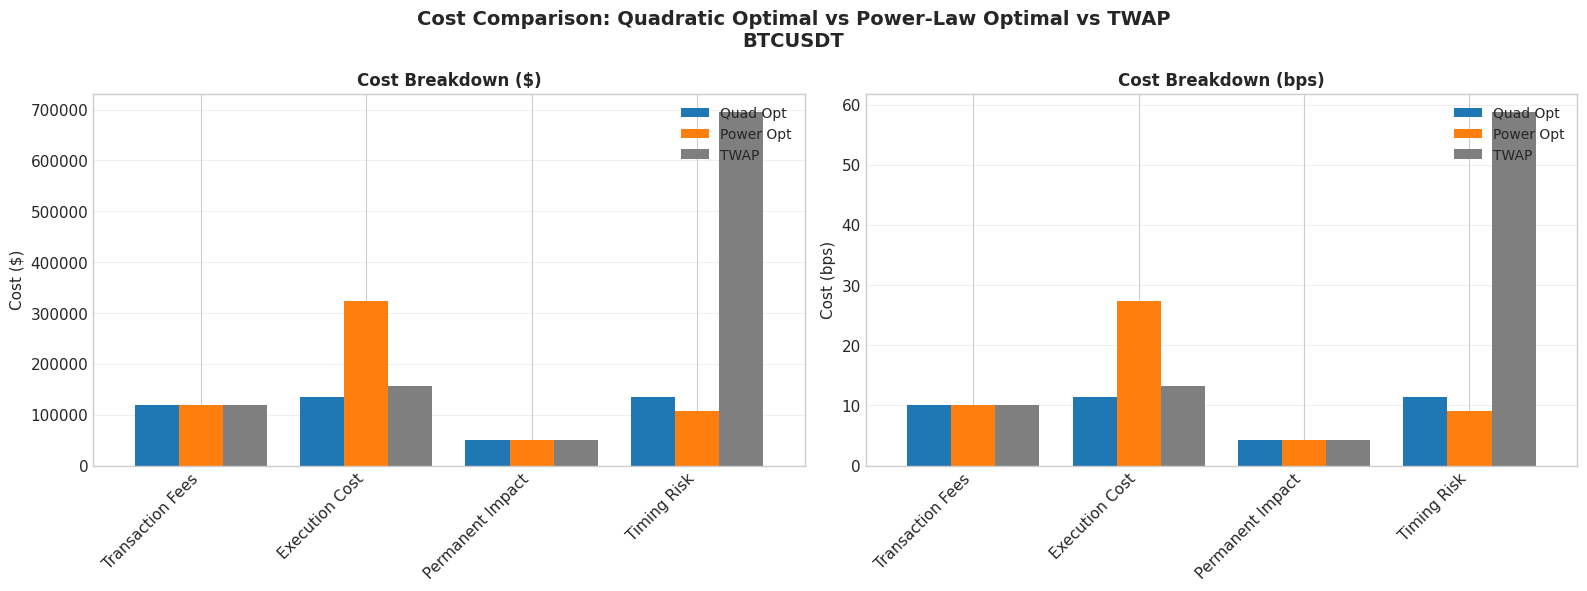

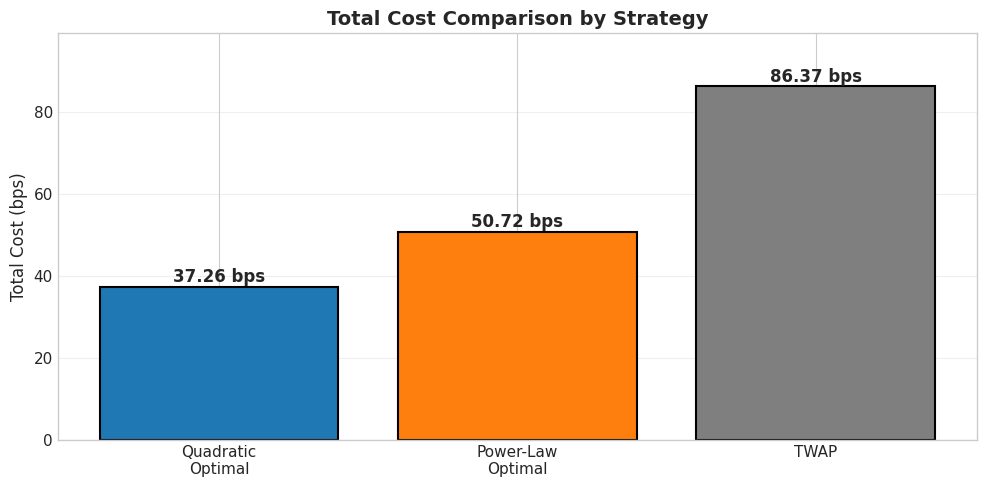


 Cost Breakdown Table:
                  Quad Opt  Power Opt   TWAP
Transaction Fees     10.00      10.00  10.00
Execution Cost       11.46      27.31  13.18
Permanent Impact      4.34       4.34   4.34
Timing Risk          11.46       9.06  58.85
TOTAL                37.26      50.72  86.37


In [62]:
if crypto_available:
    # Visualization of costs - 3 strategies comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Cost Comparison: Quadratic Optimal vs Power-Law Optimal vs TWAP\n{SYMBOL_CRYPTO}', 
                 fontsize=14, fontweight='bold')
    
    # Create comparison DataFrame
    costs_comparison_crypto = pd.DataFrame({
        'Quad Opt': [fees, exec_quad_opt, perm, risk_quad_opt, total_quad_opt],
        'Power Opt': [fees, exec_power_opt, perm, risk_power_opt, total_power_opt],
        'TWAP': [fees, exec_twap, perm, risk_twap, total_twap]
    }, index=['Transaction Fees', 'Execution Cost', 'Permanent Impact', 'Timing Risk', 'TOTAL'])
    
    costs_bps_crypto = pd.DataFrame({
        'Quad Opt': [fees_bps, exec_quad_opt_bps, perm_bps, risk_quad_opt_bps, total_quad_opt_bps],
        'Power Opt': [fees_bps, exec_power_opt_bps, perm_bps, risk_power_opt_bps, total_power_opt_bps],
        'TWAP': [fees_bps, exec_twap_bps, perm_bps, risk_twap_bps, total_twap_bps]
    }, index=['Transaction Fees', 'Execution Cost', 'Permanent Impact', 'Timing Risk', 'TOTAL'])
    
    # 1. Costs in dollars (excluding total)
    ax = axes[0]
    costs_comparison_crypto.iloc[:-1].plot(kind='bar', ax=ax, width=0.8, 
                                            color=['tab:blue', 'tab:orange', 'tab:gray'])
    ax.set_title('Cost Breakdown ($)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cost ($)')
    ax.set_xlabel('')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 2. Costs in bps (excluding total)
    ax = axes[1]
    costs_bps_crypto.iloc[:-1].plot(kind='bar', ax=ax, width=0.8,
                                     color=['tab:blue', 'tab:orange', 'tab:gray'])
    ax.set_title('Cost Breakdown (bps)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cost (bps)')
    ax.set_xlabel('')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Total cost comparison bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    strategies = ['Quadratic\nOptimal', 'Power-Law\nOptimal', 'TWAP']
    totals_bps = [total_quad_opt_bps, total_power_opt_bps, total_twap_bps]
    colors = ['tab:blue', 'tab:orange', 'tab:gray']
    
    bars = ax.bar(strategies, totals_bps, color=colors, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar, val in zip(bars, totals_bps):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                f'{val:.2f} bps', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_ylabel('Total Cost (bps)', fontsize=12)
    ax.set_title('Total Cost Comparison by Strategy', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, max(totals_bps) * 1.15)
    
    plt.tight_layout()
    plt.show()
    
    print("\n Cost Breakdown Table:")
    print(costs_bps_crypto.round(2).to_string())

## 2.5 Sensitivity Analysis on φ for Crypto

In [63]:
if crypto_available:
    # Test different values of φ for crypto
    phi_values = [0.3, 0.4, 0.5, 0.6, 0.7, 1.0]  # 1.0 = quadratic
    results_phi_crypto = []
    
    print("Sensitivity analysis on φ for crypto...\n")
    
    for phi_test in phi_values:
        print(f"   Computing for φ = {phi_test}...")
        
        model_test = AlmgrenChrissPowerLaw(
            lambda_risk=params_crypto_dict['lambda_risk'],
            sigma=params_crypto_dict['sigma'],
            k=params_crypto_dict['k'],
            phi=phi_test,
            eta=params_crypto_dict['eta'],
            psi=params_crypto_dict['psi'],
            V=params_crypto_dict['V']
        )
        
        try:
            t_test, q_test, v_test = model_test.optimal_trajectory(q0_crypto, T_crypto, N_crypto)
            costs_test = model_test.compute_costs(q0_crypto, T_crypto, N_crypto, 'optimal')
            
            results_phi_crypto.append({
                'phi': phi_test,
                'v_initial': v_test[0],
                'v_final': v_test[-1],
                'participation_initial': abs(v_test[0]) / V_crypto * 100,
                'participation_final': abs(v_test[-1]) / V_crypto * 100,
                'execution_cost': costs_test['execution_cost'] * S0_crypto,
                'total_cost': costs_test['total_cost'] * S0_crypto,
                'total_cost_bps': costs_test['total_cost'] / abs(q0_crypto) * 10000
            })
        except Exception as e:
            print(f"      Failed for φ = {phi_test}: {str(e)}")
    
    df_phi_crypto = pd.DataFrame(results_phi_crypto)
    
    print("\nResults for crypto:")
    print(df_phi_crypto[['phi', 'participation_initial', 'participation_final', 'total_cost_bps']].round(2))

Sensitivity analysis on φ for crypto...

   Computing for φ = 0.3...
   Computing for φ = 0.4...
   Computing for φ = 0.5...
   Computing for φ = 0.6...
   Computing for φ = 0.7...
   Computing for φ = 1.0...

Results for crypto:
   phi  participation_initial  participation_final  total_cost_bps
0  0.3                  71.69                 0.33           59.71
1  0.4                  63.01                 0.29           54.77
2  0.5                  58.63                 0.22           50.72
3  0.6                  56.31                 0.15           47.39
4  0.7                  55.12                 0.09           44.63
5  1.0                  54.70                 0.00           38.71


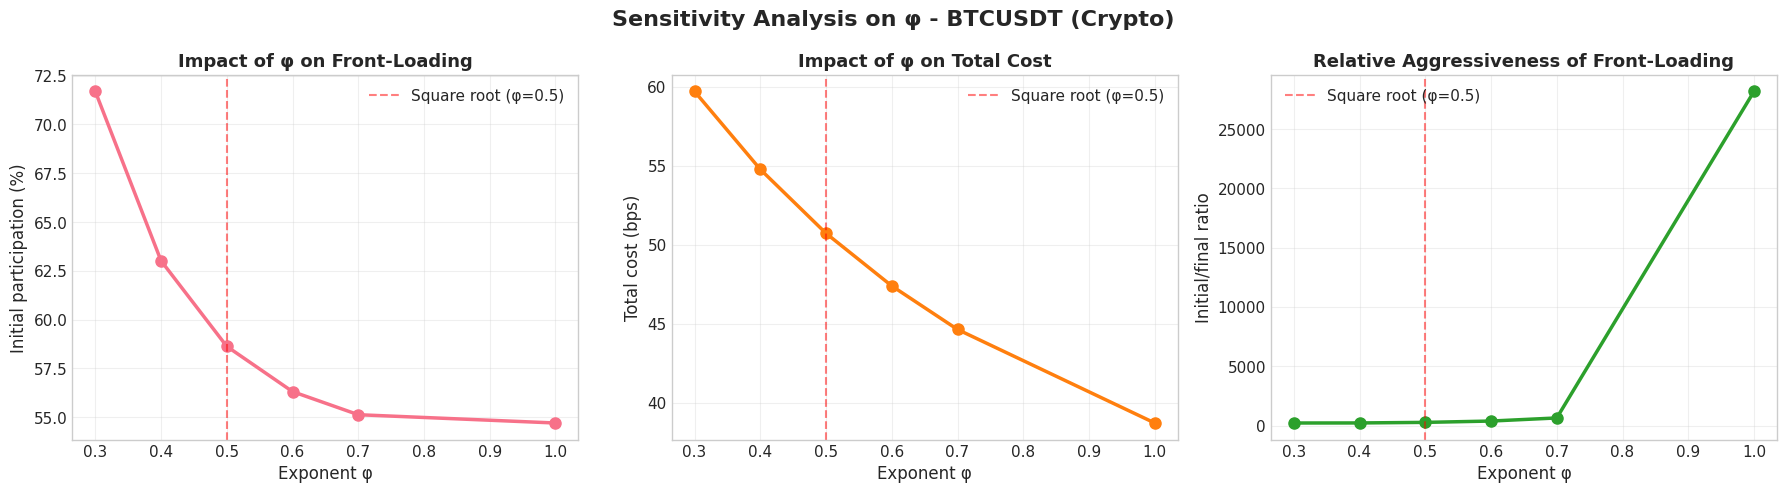


Observations for crypto:
   - Smaller φ → More aggressive front-loading (higher initial participation)
   - φ = 0.5 (square root): Empirically validated compromise
   - φ = 1.0 (quadratic): Classical Almgren-Chriss model


In [64]:
if crypto_available:
    # Sensitivity visualization for crypto
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Sensitivity Analysis on φ - {SYMBOL_CRYPTO} (Crypto)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Initial participation vs φ
    ax = axes[0]
    ax.plot(df_phi_crypto['phi'], df_phi_crypto['participation_initial'], 'o-', linewidth=2.5, markersize=8)
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
    ax.set_xlabel('Exponent φ', fontsize=12)
    ax.set_ylabel('Initial participation (%)', fontsize=12)
    ax.set_title('Impact of φ on Front-Loading', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Total cost vs φ
    ax = axes[1]
    ax.plot(df_phi_crypto['phi'], df_phi_crypto['total_cost_bps'], 'o-', linewidth=2.5, markersize=8, color='tab:orange')
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
    ax.set_xlabel('Exponent φ', fontsize=12)
    ax.set_ylabel('Total cost (bps)', fontsize=12)
    ax.set_title('Impact of φ on Total Cost', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Initial/final participation ratio vs φ
    ax = axes[2]
    ratio_crypto = df_phi_crypto['participation_initial'] / df_phi_crypto['participation_final']
    ax.plot(df_phi_crypto['phi'], ratio_crypto, 'o-', linewidth=2.5, markersize=8, color='tab:green')
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
    ax.set_xlabel('Exponent φ', fontsize=12)
    ax.set_ylabel('Initial/final ratio', fontsize=12)
    ax.set_title('Relative Aggressiveness of Front-Loading', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nObservations for crypto:")
    print(f"   - Smaller φ → More aggressive front-loading (higher initial participation)")
    print(f"   - φ = 0.5 (square root): Empirically validated compromise")
    print(f"   - φ = 1.0 (quadratic): Classical Almgren-Chriss model")

---

# Summary & Comparison

## Key Observations:

1. **Power-law vs quadratic model**:
   - The power-law model (φ=0.5) better reflects the empirical concavity of market impact
   - Significant differences in front-loading and execution costs

2. **Empirical Calibration**:
   - φ = 0.5 (square root): Broad consensus in literature (Almgren+ 2005, Kyle & Obizhaeva 2016)
   - Linear permanent impact (k): Only choice without arbitrage (Huberman & Stanzl 2004)

3. **Stock vs Crypto Differences**:
   - **Trading hours**: 6.5 hours (stocks) vs 24 hours (crypto)
   - **Volatility**: Typically lower for stocks, higher for crypto
   - **Volume patterns**: U-shaped (stocks) vs more uniform (crypto)

4. **Practical Implications**:
   - More pronounced front-loading with sub-quadratic costs
   - Importance of empirical calibration for realistic predictions
   - Trade-off between model precision and solution complexity

## Recommendations:

1. **For Research**:
   - Use φ ∈ [0.4, 0.6] based on empirical literature
   - Calibrate on real execution data
   - Test parameter sensitivity

2. **For Production**:
   - Start with φ = 0.5 (square root law)
   - Adjust based on market characteristics
   - Validate on out-of-sample data

3. **Future Extensions**:
   - Non-constant intraday volume (U-shaped curve)
   - Resilient impact (temporal decay)
   - Multi-asset execution with correlations (for example, liquidate a position of AAPL and MSFT stocks)

## Save Results

In [66]:
# Save results
import os
os.makedirs('results', exist_ok=True)

results_dict = {
    'literature_references': {
        'phi_range': [0.4, 0.7],
        'phi_recommended': 0.5,
        'sources': [
            'Almgren et al. (2005) - Direct Estimation of Equity Market Impact',
            'Kyle & Obizhaeva (2016) - Market Microstructure Invariance',
            'Bacry et al. (2015) - Market Impact: Empirical Evidence',
            'Guéant (2016) - Financial Mathematics of Market Liquidity'
        ]
    }
}

if stocks_available:
    results_dict['stock_parameters'] = params_stock_dict
    results_dict['stock_quadratic_model'] = {
        'trajectory': {
            't': t_quad_stock.tolist(),
            'q': q_quad_stock.tolist(),
            'v': v_quad_stock.tolist()
        },
        'costs': costs_quad_opt_stock
    }
    results_dict['stock_power_law_model'] = {
        'trajectory': {
            't': t_power_stock.tolist(),
            'q': q_power_stock.tolist(),
            'v': v_power_stock.tolist()
        },
        'costs': costs_power_opt_stock
    }
    results_dict['stock_sensitivity_phi'] = df_phi_stock.to_dict('records')

if crypto_available:
    results_dict['crypto_parameters'] = params_crypto_dict
    results_dict['crypto_power_law_model'] = {
        'trajectory': {
            't': t_power_crypto.tolist(),
            'q': q_power_crypto.tolist(),
            'v': v_power_crypto.tolist()
        },
        'costs': costs_power_opt_crypto
    }
    results_dict['crypto_sensitivity_phi'] = df_phi_crypto.to_dict('records')

with open('results/almgren_chriss_power_law_results.json', 'w') as f:
    json.dump(results_dict, f, indent=2, default=float)

print(" Results saved to 'results/almgren_chriss_power_law_results.json'")

 Results saved to 'results/almgren_chriss_power_law_results.json'
